# Aula 11 - Gerando Campo de Força

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares) 

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, cc
# from pyscf.geomopt.geometric_solver import optimize
from pyscf.cc import ccsd_t_lambda_slow as ccsd_t_lambda
from pyscf.grad import ccsd_t as ccsd_t_grad
from pyscf.geomopt import berny_solver

/home/elvis/Programs/miniforge3/envs/quantum/lib/python3.13/site-packages/berny/species_data.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


Baseado em https://github.com/sunqm/pyscf/blob/master/examples/geomopt/13-ccsd_t.py

## Water

Definindo a geometria inicial com conjunto de base

In [176]:
mol = gto.M(atom = [
        ['O' , (0. , 0.     , 0.   )],
        ['H' , (0. ,-0.757  ,-0.587)],
        ['H' , (0. , 0.757  ,-0.587)]],
    basis = 'aug-cc-pvdz'
)

Definindo a função de otimização da geometria usando método `CCSD(T)`

In [177]:
def f(mol):
    # Compute CCSD(T) energy
    mf = scf.RHF(mol).run()
    mycc = cc.CCSD(mf).run()
    et_correction = mycc.ccsd_t()
    e_tot = mycc.e_tot + et_correction

    # Compute CCSD(T) gradients
    g = ccsd_t_grad.Gradients(mycc).kernel()
    print('CCSD(T) nuclear gradients:')
    print(g)
    return e_tot, g

fake_method = berny_solver.as_pyscf_method(mol, f)

Cálculo da otimização da geometria

In [178]:
new_mol = berny_solver.optimize(fake_method)


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O   0.000000   0.000000   0.000000    0.000000  0.000000  0.000000
   H   0.000000  -0.757000  -0.587000    0.000000  0.000000  0.000000
   H   0.000000   0.757000  -0.587000    0.000000  0.000000  0.000000
converged SCF energy = -76.0413817223862
E(CCSD) = -76.27079064047663  E_corr = -0.2294089180904283
CCSD(T) correction = -0.00523846594403451
--------------- CCSD gradients ---------------
         x                y                z
0 O    -0.0000000000     0.0000000000    -0.0078293908
1 H    -0.0000000000     0.0048348259     0.0039146954
2 H     0.0000000000    -0.0048348259     0.0039146954
----------------------------------------------
CCSD(T) nuclear gradients:
[[-2.15875413e-17  4.90162543e-16 -7.82939083e-03]
 [-1.43882846e-16  4.83482592e-03  3.91469541e-03]
 [ 1.65470388e-16 -4.83482592e-03  3.91469541e-03]]
cycle 1: E = -76.2760291064  dE = -

Calculando a distância O-H após otimização

In [169]:
geom = new_mol.atom_coords()
d_OH1 = np.linalg.norm(geom[0] - geom[1]) * 0.529177 # convert from bohr to angstrom
d_OH2 = np.linalg.norm(geom[0] - geom[2]) * 0.529177 
print(f'Distância O-H1 após otimização: {d_OH1:.4f} Å')
print(f'Distância O-H2 após otimização: {d_OH2:.4f} Å')
print(f'Valor experimental: 0.9578 Å')
print(f'Desvio relativo: {abs(d_OH1 - 0.9578)/0.9578:.4f}')

Distância O-H1 após otimização: 0.9641 Å
Distância O-H2 após otimização: 0.9641 Å
Valor experimental: 0.9578 Å
Desvio relativo: 0.0066


Calculando o ângulo H-O-H após otimização

In [25]:
vec_OH1 = geom[1] - geom[0]
vec_OH2 = geom[2] - geom[0]
cos_theta = np.dot(vec_OH1, vec_OH2) / (np.linalg.norm(vec_OH1) * np.linalg.norm(vec_OH2))
angle_HOH = np.degrees(np.arccos(cos_theta))
print(f'Ângulo H-O-H após otimização: {angle_HOH:.2f}°')
print(f'Valor experimental: 104.49°')
print(f'Desvio relativo: {abs(angle_HOH - 104.49)/104.49:.4f}')

Ângulo H-O-H após otimização: 104.13°
Valor experimental: 104.49°
Desvio relativo: 0.0034


In [170]:
mf = scf.RHF(new_mol).run()
mycc = cc.CCSD(mf).run()
et_correction = mycc.ccsd_t()
e_tot = mycc.e_tot + et_correction

converged SCF energy = -76.0409319423998
E(CCSD) = -76.27085915560556  E_corr = -0.2299272132057449
CCSD(T) correction = -0.0052862123446446


Comparando energias da molécula

In [27]:
print(f'Energia Final CCSD(T): {e_tot:.3f} Eh')
print(f'Valor experimental: -76.438 Eh')
print(f'Desvio relativo: {abs(e_tot + 76.438)/76.438:.4f}')

Energia Final CCSD(T): -76.276 Eh
Valor experimental: -76.438 Eh
Desvio relativo: 0.0021


## Passo 2: Cálculo da Hessiana - Termos Ligantes

In [ ]:
from pyscf.hessian import thermo
hessian = mf.Hessian().kernel()

print('CCSD(T) Hessian:')
print(hessian)

CCSD(T) Hessian:
[[[[ 2.50402323e-02 -6.28973332e-17 -2.62025651e-16]
   [-6.28973712e-17  6.80008852e-01 -1.54152095e-15]
   [-2.62019488e-16 -1.90278874e-15  5.11448276e-01]]

  [[-1.25201162e-02  2.19274537e-16  2.92225653e-16]
   [ 2.81899892e-16 -3.40004426e-01 -2.64723411e-01]
   [ 2.16995138e-16 -2.00146067e-01 -2.55724138e-01]]

  [[-1.25201162e-02 -1.56377166e-16 -3.02061647e-17]
   [-2.19002559e-16 -3.40004426e-01  2.64723411e-01]
   [ 4.50305128e-17  2.00146067e-01 -2.55724138e-01]]]


 [[[-1.25201162e-02  2.81899892e-16  2.16995138e-16]
   [ 2.19274537e-16 -3.40004426e-01 -2.00146067e-01]
   [ 2.92225653e-16 -2.64723411e-01 -2.55724138e-01]]

  [[ 1.06827490e-02 -2.73995850e-16 -2.27158066e-16]
   [-2.73994580e-16  3.76754755e-01  2.32434738e-01]
   [-2.27156445e-16  2.32434746e-01  2.39279767e-01]]

  [[ 1.83736718e-03 -7.90528353e-18  1.01644180e-17]
   [ 5.47188758e-17 -3.67503295e-02 -3.22886653e-02]
   [-6.50707403e-17  3.22886715e-02  1.64443711e-02]]]


 [[[-1.252011

Analisando os modos normais

In [ ]:
freq_info = thermo.harmonic_analysis(mf.mol, hessian)

thermo.dump_normal_mode(new_mol, freq_info)

Mode                                 0                   1                   2
Irrep
Freq [cm^-1]                     1840.7975           3872.9786           3949.1109
Reduced mass [au]                   1.0807              1.0473              1.0796
Force const [Dyne/A]                2.1576              9.2561              9.9203
Char temp [K]                    2648.4977           5572.3539           5681.8914
Normal mode                   x     y     z       x     y     z       x     y     z
       0   O                -0.00  0.00 -0.07    0.00 -0.00  0.05   -0.00 -0.07 -0.00
       1   H                 0.00 -0.42  0.53   -0.00 -0.56 -0.40    0.00  0.53  0.43
       2   H                 0.00  0.42  0.53    0.00  0.56 -0.40    0.00  0.53 -0.43


#### Outra opção: Calculando energias diretamente

$E_\text{bond} = E_0 + \frac{1}{2}k_b (l-l_0)^2$

In [88]:
# modificando o comprimento de ligação O-H para vários valores e calculando as energias CCSD(T)
lengths = np.arange(0.945, 0.985, 0.005) 
energies = np.zeros_like(lengths)
for i, length in enumerate(lengths):
    mol_temp = gto.M(atom = f'O 0.000 0.000 0.000;\
                               H 0. {-length*np.sin(0.5*np.radians(angle_HOH))} {length*np.cos(0.5*np.radians(angle_HOH))}; \
                               H 0. {length*np.sin(0.5*np.radians(angle_HOH))} {length*np.cos(0.5*np.radians(angle_HOH))}',
                    basis = 'aug-cc-pvdz', verbose = 0)
    mf_temp = scf.RHF(mol_temp).run()
    mycc_temp = cc.CCSD(mf_temp).run()
    et_correction_temp = mycc_temp.ccsd_t()
    e_tot_temp = mycc_temp.e_tot + et_correction_temp
    energies[i] = e_tot_temp
    print(f'Length: {length:.2f} Å, Energy: {e_tot_temp:.6f} Eh')

Length: 0.94 Å, Energy: -76.275288 Eh
Length: 0.95 Å, Energy: -76.275657 Eh
Length: 0.95 Å, Energy: -76.275921 Eh
Length: 0.96 Å, Energy: -76.276085 Eh
Length: 0.96 Å, Energy: -76.276150 Eh
Length: 0.97 Å, Energy: -76.276121 Eh
Length: 0.97 Å, Energy: -76.276001 Eh
Length: 0.98 Å, Energy: -76.275794 Eh
Length: 0.98 Å, Energy: -76.275501 Eh


Text(0, 0.5, 'E-E_0 (Eh)')

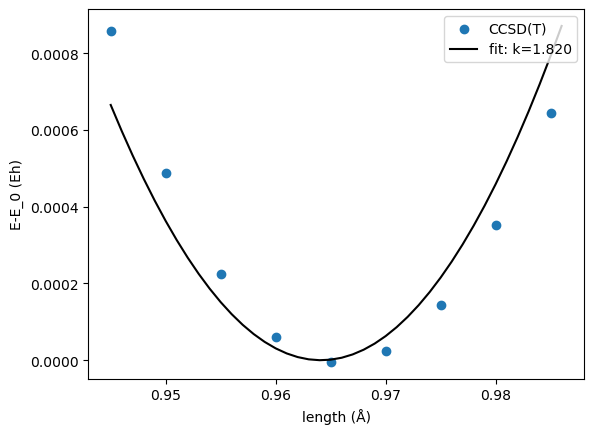

In [89]:
from scipy.optimize import curve_fit

def func(x, k):
    return 2*0.5*k * (x-d_OH1)**2 + e_tot # Cuidado! Aqui temos duas ligações O-H

popt_d, pcov_d = curve_fit(func, lengths, energies, p0=[1.5])

lengths_new = np.arange(lengths[0], lengths[-1]+0.001, 0.001)

plt.scatter(lengths, energies-e_tot, marker='o', label = 'CCSD(T)')
plt.plot(lengths_new, func(lengths_new, *popt_d)-e_tot, 'k',label='fit: k=%5.3f' % tuple(popt_d))
plt.legend(loc='upper right')
plt.xlabel('length (Å)')
plt.ylabel('E-E_0 (Eh)') 

In [90]:
k_b = popt_d[0]* 627.509 # convert Hartree to kilocalories per mole 

print(f'Constante de força k_b: {k_b:.3f} kcal/(mol·Å²)')

Constante de força k_b: 1141.907 kcal/(mol·Å²)


$E_\text{angle} = E_0 + \frac{1}{2}k_\theta (\theta-\theta_0)^2$

In [75]:
# modificando o ângulo de ligação H-O-H para vários valores e calculando as energias CCSD(T)
angles = np.arange(100, 109, 1.0) 
energies = np.zeros_like(angles)
for i, angle in enumerate(angles):
    mol_temp = gto.M(atom = f'O 0.000 0.000 0.000;\
                               H 0. {-d_OH1*np.sin(0.5*np.radians(angle))} {d_OH1*np.cos(0.5*np.radians(angle))}; \
                               H 0. {d_OH2*np.sin(0.5*np.radians(angle))} {d_OH2*np.cos(0.5*np.radians(angle))}',
                    basis = 'aug-cc-pvdz', verbose = 0)
    mf_temp = scf.RHF(mol_temp).run()
    mycc_temp = cc.CCSD(mf_temp).run()
    et_correction_temp = mycc_temp.ccsd_t()
    e_tot_temp = mycc_temp.e_tot + et_correction_temp
    energies[i] = e_tot_temp
    print(f'angle: {angle:.2f} degrees, Energy: {e_tot_temp:.6f} Eh')

angle: 100.00 degrees, Energy: -76.275733 Eh
angle: 101.00 degrees, Energy: -76.275913 Eh
angle: 102.00 degrees, Energy: -76.276042 Eh
angle: 103.00 degrees, Energy: -76.276119 Eh
angle: 104.00 degrees, Energy: -76.276146 Eh
angle: 105.00 degrees, Energy: -76.276123 Eh
angle: 106.00 degrees, Energy: -76.276052 Eh
angle: 107.00 degrees, Energy: -76.275933 Eh
angle: 108.00 degrees, Energy: -76.275768 Eh


Text(0, 0.5, 'E-E_0 (Eh)')

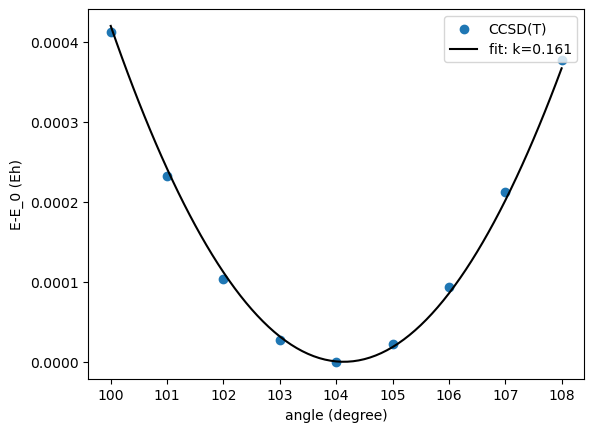

In [76]:
from scipy.optimize import curve_fit

def func(x, k):
    return 0.5*k * (np.radians(x)-np.radians(angle_HOH))**2 + e_tot

popt_theta, pcov_theta = curve_fit(func, angles, energies, p0=[0.3])

angles_new = np.arange(angles[0], angles[-1]+0.1, 0.1)

plt.scatter(angles, energies-e_tot, marker='o', label = 'CCSD(T)')
plt.plot(angles_new, func(angles_new, *popt_theta)-e_tot, 'k',label='fit: k=%5.3f' % tuple(popt_theta))
plt.legend(loc='upper right')
plt.xlabel('angle (degree)')
plt.ylabel('E-E_0 (Eh)') 

In [77]:
k_theta = popt_theta[0]* 627.509 # convert Hartree to kilocalories per mole 

print(f'Constante de força k_theta: {k_theta:.3f} kcal/(mol·rad²)')

Constante de força k_theta: 101.224 kcal/(mol·rad²)


## Passo 3: Cálculo da ESP - Termo Eletrostático

In [97]:
dm = mf.make_rdm1()  # to_cpu

In [111]:
from gpu4pyscf.pop import esp

# ESP charge
q0 = esp.esp_solve(new_mol, dm)
print('Fitted ESP charge')
print(q0)

Fitted ESP charge
[-0.72845263  0.36422632  0.36422632]


In [112]:
# RESP charge // first stage fitting
q1 = esp.resp_solve(new_mol, dm)

# Constraint for equal charges
# equal_constraints = [
#     [i,j,k],
#     [u,v,w]]
#     -->
#     q[i] = q[j] = q[k] = q[l]
#     q[u] = q[v] = q[w]
equal_constraints = [[1,2]] # H atoms in H2O are equal

# RESP charge // second stage fitting
q2 = esp.resp_solve(new_mol, dm, resp_a=1e-3,
                    equal_constraints=equal_constraints)
print('Fitted partial charge with RESP')
print(q2)

Fitted partial charge with RESP
[-0.72445366  0.36222683  0.36222683]


In [175]:
qO = -0.724
qH = -qO/2

print(f'Oxygen charge: {qO:.6f} e')
print(f'Hydrogen charge: {qH:.6f} e')

Oxygen charge: -0.724000 e
Hydrogen charge: 0.362000 e


# Passo 3: Interação entre duas moléculas de H2O

In [159]:
mol_cluster = gto.M(
    atom= '''O -1.5614 -0.8255 0.5368
            H -0.6305 -0.8758 0.2588
            H -1.9991 -1.5191 0.0288
            O 1.2821 -0.7524 -0.1108
            H 1.5168 0.1326 -0.4203
            H 1.7973 -0.8645 0.6993''',
    basis = 'aug-cc-pvdz')

mol_cluster.tofile('water_2_Cs.xyz')

'6\nXYZ from PySCF\nO          -1.56140000       -0.82550000        0.53680000\nH          -0.63050000       -0.87580000        0.25880000\nH          -1.99910000       -1.51910000        0.02880000\nO           1.28210000       -0.75240000       -0.11080000\nH           1.51680000        0.13260000       -0.42030000\nH           1.79730000       -0.86450000        0.69930000'

In [184]:
1.2821-(-1.5614)

2.8434999999999997

In [183]:
distance = np.arange(1.0, 1.5, 0.05) 
energies = np.zeros_like(distance)
for i, d in enumerate(distance):
    mol_temp = gto.M(atom = f'O -1.5614 -0.8255 0.5368;\
                            H -0.6305 -0.8758 0.2588;\
                            H -1.9991 -1.5191 0.0288;\
                            O {d} -0.7524 -0.1108;\
                            H {d+0.23469} 0.1326 -0.4203; \
                            H {d+0.5152} -0.8645 0.6993',
                    basis = 'aug-cc-pvdz', verbose = 0)
    mf_temp = scf.RHF(mol_temp).run()
    mycc_temp = cc.CCSD(mf_temp).run()
    et_correction_temp = mycc_temp.ccsd_t()
    e_tot_temp = mycc_temp.e_tot + et_correction_temp
    energies[i] = e_tot_temp
    print(f'Distance: {d:.2f} Å, Energy: {e_tot_temp:.6f} Eh')

Distance: 1.00 Å, Energy: -152.558418 Eh
Distance: 1.05 Å, Energy: -152.559349 Eh
Distance: 1.10 Å, Energy: -152.560008 Eh
Distance: 1.15 Å, Energy: -152.560447 Eh
Distance: 1.20 Å, Energy: -152.560711 Eh
Distance: 1.25 Å, Energy: -152.560838 Eh
Distance: 1.30 Å, Energy: -152.560856 Eh
Distance: 1.35 Å, Energy: -152.560791 Eh
Distance: 1.40 Å, Energy: -152.560661 Eh
Distance: 1.45 Å, Energy: -152.560483 Eh


Text(0, 0.5, 'E (Eh)')

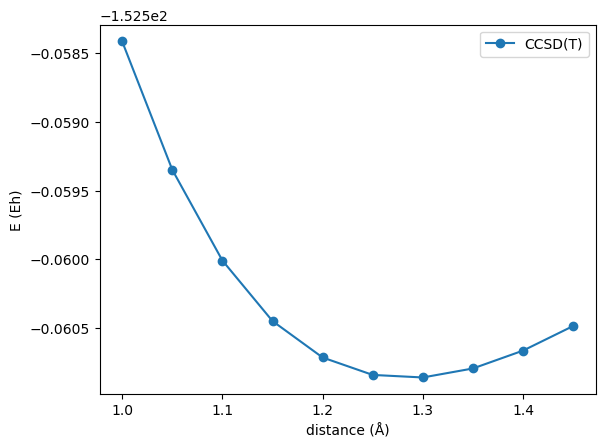

In [185]:
plt.plot(distance, energies, marker='o', label='CCSD(T)')
plt.legend(loc='upper right')
plt.xlabel('distance (Å)')
plt.ylabel('E (Eh)') 

Ainda não feito

In [171]:
geom = mol_cluster.atom_coords()

E_pot = 2*e_tot

# Calculando a energia de ligação O-H1 e O-H2
d_O1H1 = np.linalg.norm(geom[0] - geom[1]) * 0.529177 
E_pot += 0.5 * (k_b / 627.509) * (d_O1H1 - d_OH1)**2
d_O1H2 = np.linalg.norm(geom[0] - geom[2]) * 0.529177 
E_pot += 0.5 * (k_b / 627.509) * (d_O1H2 - d_OH1)**2
d_O2H1 = np.linalg.norm(geom[3] - geom[4]) * 0.529177 
E_pot += 0.5 * (k_b / 627.509) * (d_O1H1 - d_OH1)**2
d_O2H2 = np.linalg.norm(geom[3] - geom[5]) * 0.529177 
E_pot += 0.5 * (k_b / 627.509) * (d_O1H2 - d_OH1)**2

# Calculando as energias de ângulo H-O-H
vec_O1H1 = geom[1] - geom[0]
vec_O1H2 = geom[2] - geom[0]
cos_theta1 = np.dot(vec_O1H1, vec_O1H2) / (np.linalg.norm(vec_O1H1) * np.linalg.norm(vec_O1H2))
angle_HOH1 = np.degrees(np.arccos(cos_theta1))
E_pot += 0.5 * (k_theta / 627.509) * (np.radians(angle_HOH1) - np.radians(angle_HOH))**2
vec_O2H1 = geom[4] - geom[3]
vec_O2H2 = geom[5] - geom[3]
cos_theta2 = np.dot(vec_O2H1, vec_O2H2) / (np.linalg.norm(vec_O2H1) * np.linalg.norm(vec_O2H2))
angle_HOH2 = np.degrees(np.arccos(cos_theta2))
E_pot += 0.5 * (k_theta / 627.509) * (np.radians(angle_HOH2) - np.radians(angle_HOH))**2

# calculando as energias eletrostáticas entre as moléculas de água
E_pot += (qO * qO) / (np.linalg.norm(geom[0] - geom[3]) ) 
E_pot += (qH * qH) / (np.linalg.norm(geom[1] - geom[4]) )
E_pot += (qH * qH) / (np.linalg.norm(geom[1] - geom[5]) )
E_pot += (qH * qH) / (np.linalg.norm(geom[2] - geom[4]) )
E_pot += (qH * qH) / (np.linalg.norm(geom[2] - geom[5]) )

print(f'Calculated potential energy: {E_pot:.6f} Eh')

Calculated potential energy: -152.365394 Eh


In [172]:
E_ccsdt = -1.525497863347E+02

In [173]:
E_lj = E_ccsdt -E_pot

In [174]:
sigma = 3.1507 
r = np.linalg.norm(geom[0] - geom[3]) * 0.529177 

epsilon = (E_lj) / (4*((sigma/r)**12 - (sigma/r)**6))
print(f'Calculated Lennard-Jones epsilon: {epsilon*627.509:.6f} kcal/mol')

Calculated Lennard-Jones epsilon: -31.040355 kcal/mol
